# 한국투자증권 거래내역 및 계좌잔고 조회

## 준비작업

### 1. 아래 버튼을 눌러 Notebook을 Colab에서 엽니다.

In [4]:
# TODO - 버튼 연결

### 2. 개인 보안 정보를 입력하세요

데이터를 조회하기 위해 필요한 아래 정보들을 채워 넣습니다.
- `app_key`: 한국투자증권 OpenAPI 포털에서 발행한 App key
- `app_secret`: 한국투자증권 OpenAPI 포털에서 발행한 App secret
- `cano`: 한국투자증권 계좌번호 (전체 계좌번호가 12345678-12인 경우 12345678를 입력)
- `acnt_prdt_cd`: 한국투자증권 계좌상품번호 (전체 계좌번호가 12345678-12인 경우 12를 입력)

    >**Tip!**
    >
    >위의 개인 보안 정보들을 채워 넣은 후 `CTRL-F9` (Windows) or `⌘-F9` (Mac)를 눌러 전체 노트북을 다시 시작 할 수 있습니다..


In [ ]:
%pip install pyqqq

import datetime as dtm
import pandas as pd

app_key = '<한국투자증권_OPENAPI_APP_KEY>'
app_secret = '<한국투자증권_OPENAPI_APP_SECRET>'
cano = '<한국투자증권_계좌번호>'
acnt_prdt_cd = '<한국투자증권_계좌상품번호>'

In [3]:
from pyqqq.brokerage.kis.oauth import KISAuth
from pyqqq.brokerage.kis.simple import KISSimpleDomesticStock

auth = KISAuth(app_key, app_secret)
simple_api = KISSimpleDomesticStock(auth, cano, acnt_prdt_cd)
stock_api = simple_api.stock_api

## 보유 주식 잔고 조회

In [7]:
def get_balance(include_sold=False):
    ctx_area_fk100 = ''
    ctx_area_nk100= ''
    tr_cont = ''
    fetching = True

    positions = []

    while fetching:

        r = stock_api.inquire_balance(cano, acnt_prdt_cd, '02', ctx_area_fk100=ctx_area_fk100, ctx_area_nk100=ctx_area_nk100, tr_cont=tr_cont)

        for data in r['output1']:
            holding_qty = int(data["hldg_qty"])
            if not include_sold and holding_qty == 0:
                continue

            positions.append(
                {
                    "code": data["pdno"],
                    "name": data["prdt_name"],
                    "pnl": data["evlu_pfls_amt"],
                    "pnl_rate": data["evlu_pfls_rt"],
                    "holding_qty": holding_qty,
                    "current_value": data["evlu_amt"],
                    "current_price": data["prpr"],
                    "average_purchase_price": int(data["pchs_avg_pric"]),
                    "purchase_value": data["pchs_amt"],
                    "lastday_price_diff": data["bfdy_cprs_icdc"],
                }
            )

        if r["tr_cont"] in ["F", "M"]:
            ctx_area_nk100 = r['ctx_area_nk100']
            ctx_area_fk100 = r['ctx_area_fk100']
            tr_cont = "N"
        else:
            fetching = False

    positions_df = pd.DataFrame(positions)
    if len(positions) > 0:
        positions_df = positions_df.sort_values(by="pnl_rate", ascending=False)
        positions_df.rename(columns={
            "code": "종목코드",
            "name": "종목명",
            "pnl": "평가손익",
            "pnl_rate": "수익률",
            "holding_qty": "보유수량",
            "current_value": "평가금액",
            "average_purchase_price": "매입단가",
            "purchase_value": "매입금액",
            "current_price": "현재가",
            "lastday_price_diff": "전일대비",
        }, inplace=True)
        positions_df.set_index("종목코드", inplace=True)

    output2 = r['output2'][0]

    purchase_amount = output2["pchs_amt_smtl_amt"]
    current_amount = output2["evlu_amt_smtl_amt"]
    pnl_amount = output2["evlu_pfls_smtl_amt"] - output2["thdt_tlex_amt"]
    pnl_rate = int(pnl_amount) / int(purchase_amount) * 100 if purchase_amount > 0 else 0

    statistics = {
        "purchase_amount": purchase_amount,
        "current_amount": current_amount,
        "pnl": pnl_amount,
        "pnl_rate": pnl_rate,
    }

    net_df = pd.DataFrame([statistics])
    net_df.rename(index={0: "총합"}, inplace=True)
    net_df.rename(columns={
        "purchase_amount": "매입금액",
        "current_amount": "평가금액",
        "pnl": "평가손익",
        "pnl_rate": "수익률",
    }, inplace=True)

    return positions_df, net_df

positions_df, net_df = get_balance()

display(net_df)

if positions_df.size:
    def make_clickable(val):
        return f'<a href="https://finance.naver.com/item/main.nhn?code={val}">{val}</a>'
    html_positions_df = positions_df.style.format_index(make_clickable, axis=0)
    display(html_positions_df)
else:
    print("보유 중인 주식이 없습니다")

,매입금액,평가금액,평가손익,수익률
총합,0,0,0,0


보유 중인 주식이 없습니다


## 매매손익

In [4]:
def get_today_pnl_and_trades(target_date: dtm.date = None):
    ctx_area_fk100 = ''
    ctx_area_nk100= ''
    tr_cont = ''

    if target_date is None:
        target_date = dtm.date.today()

    trades = []

    fetching = True

    asset_codes = set()

    while fetching:
        r = stock_api.inquire_period_trade_profit(
            cano, acnt_prdt_cd, target_date, target_date,
            ctx_area_fk100=ctx_area_fk100,
            ctx_area_nk100=ctx_area_nk100,
            tr_cont=tr_cont
        )

        for data in r['output1']:
            if data["sll_qty"] == 0:
                continue

            row = {
                "종목코드": data["pdno"][-6:],
                "종목명": data["prdt_name"],
                "실현손익": data["rlzt_pfls"],
                "손익률": data["pfls_rt"],
                "매수금액": data["buy_amt"],
                "매도금액": data["sll_amt"],
                "매수수량": data["buy_qty"],
                "매도수량": data["sll_qty"],
                "매수단가": int(data["buy_amt"] / data["buy_qty"]),
                "매도단가": int(data["sll_amt"] / data["sll_qty"]),
                "현재가": 0,
                "수수료": data["fee"],
                "제세금": data["tl_tax"],
                "매매일": data["trad_dt"],
            }
            trades.append(row)
            asset_codes.add(row["종목코드"][-6:])

        if r["tr_cont"] in ["F", "M"]:
            ctx_area_nk100 = r['ctx_area_nk100']
            ctx_area_fk100 = r['ctx_area_fk100']
            tr_cont = "N"
        else:
            fetching = False

    if asset_codes:
        current_prices_df = simple_api.get_price_for_multiple_stock(list(asset_codes))

    if trades:
        trades_df = pd.DataFrame(trades)
        trades_df.sort_values(by="실현손익", ascending=False, inplace=True)
        trades_df.set_index("종목코드", inplace=True)

        for code in asset_codes:
            trades_df.loc[code, "현재가"] = current_prices_df.loc[code, "current_price"]
    else:
        trades_df = pd.DataFrame()

    output2 = r['output2']
    net_data = {
        "매도금액": output2["sll_excc_amt_smtl"],
        "매수금액": output2["buy_excc_amt_smtl"],
        "매매비용": output2["tot_fee"],
        "제세금": output2["tot_tltx"],
        "실현손익": output2["tot_rlzt_pfls"],
        "실현손익률": output2["tot_pftrt"],
    }
    net_df = pd.DataFrame([net_data])
    net_df.rename(index={0: "총합"}, inplace=True)

    return trades_df, net_df

trades_df, net_df = get_today_pnl_and_trades()

display(net_df)
display(trades_df) if trades_df.size else "오늘의 매매가 없습니다"

,매도금액,매수금액,매매비용,제세금,실현손익,실현손익률
총합,0,0,0,0,0,0E-8


'오늘의 매매가 없습니다'

## 주문 내역

In [13]:
def get_order_history(target_date: dtm.date=None):
    ctx_area_fk100 = ''
    ctx_area_nk100= ''
    tr_cont = ''

    if target_date is None:
        target_date = dtm.date.today()

    orders = []
    fetching = True

    while fetching:
        r = stock_api.inquire_daily_ccld(
            cano, acnt_prdt_cd, target_date, target_date, ctx_area_fk100=ctx_area_fk100, ctx_area_nk100=ctx_area_nk100, tr_cont=tr_cont
        )

        for data in r['output1']:
            row = {
                "종목코드": data["pdno"][-6:],
                "종목명": data["prdt_name"],
                "주문량": data["ord_qty"],
                "체결량": data["tot_ccld_qty"],
                "주문단가": data["ord_unpr"],
                "체결평균": data["avg_prvs"],
                "총체결금액": data["tot_ccld_amt"],
                "구분": data["sll_buy_dvsn_cd_name"],
                "주문유형": data["ord_dvsn_name"],
                "미체결량": data["rmn_qty"],
                "취소수량": data["cncl_cfrm_qty"],
                "주문번호": data["odno"],
                "원주문": data.get("orgn_odno", ""),
                "주문시간": data["ord_tmd"],
                "주문일": data["ord_dt"],
            }
            orders.append(row)

        if r["tr_cont"] in ["F", "M"]:
            ctx_area_nk100 = r['ctx_area_nk100']
            ctx_area_fk100 = r['ctx_area_fk100']
            tr_cont = "N"
        else:
            fetching = False

    orders_df = pd.DataFrame(orders)
    orders_df.sort_values(by="주문시간", ascending=False, inplace=True)
    orders_df.set_index("종목코드", inplace=True)

    return orders_df

get_order_history()

,종목명,주문량,체결량,주문단가,체결평균,총체결금액,구분,주문유형,미체결량,취소수량,주문번호,원주문,주문시간,주문일
종목코드,,,,,,,,,,,,,,
060280,큐렉소,2,2,0,14630,29260,현금매수,시장가,0,0,0000063266,,09:35:59,20240319
264850,이랜시스,3,3,0,8800,26400,현금매수,시장가,0,0,0000059650,,09:31:51,20240319
222810,세토피아,19,19,0,1544,29336,현금매수,시장가,0,0,0000057568,,09:29:46,20240319
340360,다보링크,11,11,0,2600,28600,현금매수,시장가,0,0,0000057085,,09:29:15,20240319
008830,대동기어,2,2,0,11130,22260,현금매수,시장가,0,0,0000056570,,09:28:44,20240319
099440,스맥,7,7,0,3905,27335,현금매수,시장가,0,0,0000056568,,09:28:43,20240319
042520,한스바이오메드,1,1,0,15940,15940,현금매수,시장가,0,0,0000056565,,09:28:43,20240319
001780,알루코,8,8,0,3655,29240,현금매수,시장가,0,0,0000056560,,09:28:43,20240319
086960,MDS테크,15,15,0,1885,28275,현금매수,시장가,0,0,0000056554,,09:28:42,20240319


## 기간 손익 일별 합산 조회

In [5]:
def get_period_profit(start_date: dtm.date, end_date: dtm.date):

    fetching = True
    tr_cont = ''
    ctx_area_fk100 = ''
    ctx_area_nk100= ''

    bucket = []

    while fetching:
        r = stock_api.inquire_period_profit(cano, acnt_prdt_cd, start_date, end_date, tr_cont=tr_cont, ctx_area_fk100=ctx_area_fk100, ctx_area_nk100=ctx_area_nk100)

        for data in r['output1']:
            bucket.append(data)

        if r["tr_cont"] in ["F", "M"]:
            ctx_area_nk100 = r['ctx_area_nk100']
            ctx_area_fk100 = r['ctx_area_fk100']
            tr_cont = "N"
        else:
            fetching = False

    df = pd.DataFrame(bucket)
    df.sort_values(by="trad_dt", inplace=True)

    # rlzt_pfls 컬럼 값을 누적하는 새로운 컬럼을 만들어줍니다.
    df["누적실현손익"] = df["rlzt_pfls"].cumsum()
    df.rename(columns={
        'trad_dt': '매매일자',
        'buy_amt': '매수금액',
        'sll_amt': '매도금액',
        'rlzt_pfls': '실현손익',
        'fee': '수수료',
        'tl_tax': '제세금',
        'pfls_rt': '수익률',
        'sll_qty1': '매도수량',
        'buy_qty1': '매수수량',
    }, inplace=True)

    df.set_index("매매일자", inplace=True)

    return df


end_date = dtm.date.today()
start_date = end_date - dtm.timedelta(days=30)

df = get_period_profit(start_date, end_date)
df

,매수금액,매도금액,실현손익,수수료,loan_int,제세금,수익률,매도수량,매수수량,누적실현손익
매매일자,,,,,,,,,,
2024-03-06,30310,16965,-5,0,0,0,-0.02946376,1,2,-5
2024-03-07,33875,16940,5,0,0,0,0.02952465,1,2,0
2024-03-11,1023453,1049273,-6280,0,0,1820,-0.59597640,134,132,-6280
2024-03-12,975444,963085,-14090,10,0,1721,-1.44447042,139,139,-20370
2024-03-13,1740258,1717424,-25925,33,0,3058,-1.48972164,177,177,-46295
2024-03-18,869660,849770,-21434,24,0,1520,-2.46464135,35,35,-67729
2024-03-19,423566,419030,-5281,0,0,745,-1.24679507,91,91,-73010


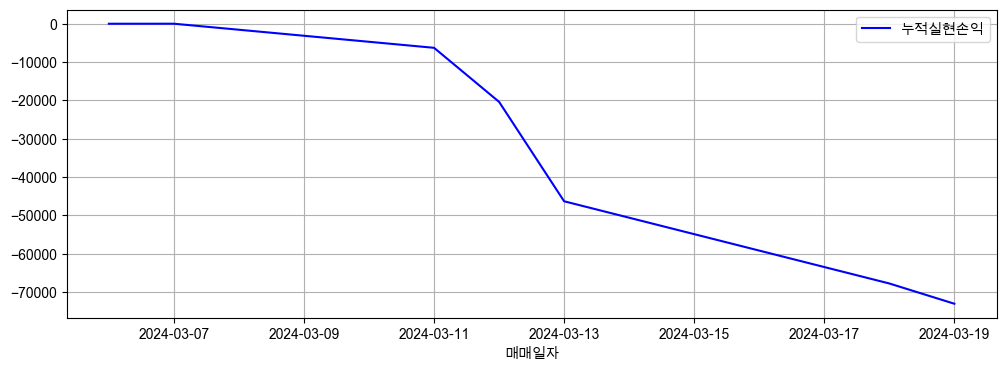

In [6]:
# | echo: false

import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', family='Arial Unicode MS')

ax = df[["누적실현손익"]].plot(figsize=(12, 4), style=["b-"])
plt.grid(True)
plt.show()